#Introduction


This project aims to analyze product data from the Ulta website through a comprehensive workflow that includes web scraping, data cleaning, analysis, and visualization. By examining product information such as names, brands, prices, and ratings, the project seeks to uncover insights into the distribution and relationships of these attributes, providing a deeper understanding of the product landscape on Ulta's platform.

#Libraries

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import re
from scipy.stats import skew, kurtosis


#1.Data Collection(Scraping)

In the data collection phase, I utilize web scraping techniques to gather product information from Ulta's website. Using tools like BeautifulSoup and requests, I extract details such as product names, brands, prices, and ratings from multiple pages. This data is then stored in a structured format using a Pandas DataFrame, setting the foundation for further analysis.

In [3]:
def scrape_ulta_page(page_num):
    url = f"https://www.ulta.com/shop/makeup/all?page={page_num}"
    data = requests.get(url)

    if data.status_code != 200:
        print(f"Error fetching page {page_num}: {data.status_code}")
        return None

    soup = BeautifulSoup(data.content, "html.parser")
    product_cards = soup.find_all("div", class_="ProductCard__content")

    product_data = []
    for card in product_cards:
        product_name = card.find("span", class_="ProductCard__product")
        brand_name = card.find("span", class_="ProductCard__brand")
        price = card.find("div", class_="ProductPricing")
        rating = card.find("div", class_="ProductCard__rating")

        product_data.append({
            "Name": product_name.text.strip() if product_name else "N/A",
            "Brand": brand_name.text.strip() if brand_name else "N/A",
            "Price": price.text.strip() if price else "N/A",
            "Rating": rating.text.strip() if rating else "N/A"
        })
    return product_data

all_product_data = []
# Scraping from page 1 up to page 20. Amount of all pages are 87, but I used only 20 for faster running.
for page_num in range(1, 20):
    page_data = scrape_ulta_page(page_num)
    if page_data:
        all_product_data.extend(page_data)

df = pd.DataFrame(all_product_data)

In [4]:
df

,Name,Brand,Price,Rating
0,Double Wear Stay-in-Place Foundation,Estée Lauder,$52.00,
1,CC+ Cream with SPF 50+,IT Cosmetics,$47.00,
2,"Precisely, My Brow Pencil Waterproof Eyebrow D...",Benefit Cosmetics,$27.00,
3,Radiant Creamy Concealer,NARS,$32.00,
4,Shape Tape Concealer,Tarte,$32.00,
...,...,...,...,...
1211,Teint Idole Ultra Wear Skin Refining Setting P...,Lancôme,$45.00,
1212,Solar Flare Lip Topper,ULTA Beauty Collection,$12.00,
1213,Cheek Squad Cream Face Trio,ULTA Beauty Collection,$16.00,
1214,Lifter Gloss Candy Drop Lip Gloss with Hyaluro...,Maybelline,$10.99,


In [6]:
df['Name']


,Name
0,Double Wear Stay-in-Place Foundation
1,CC+ Cream with SPF 50+
2,"Precisely, My Brow Pencil Waterproof Eyebrow D..."
3,Radiant Creamy Concealer
4,Shape Tape Concealer
...,...
1211,Teint Idole Ultra Wear Skin Refining Setting P...
1212,Solar Flare Lip Topper
1213,Cheek Squad Cream Face Trio
1214,Lifter Gloss Candy Drop Lip Gloss with Hyaluro...


#2.Data Cleaning & Data Preprocessing


The data cleaning and preprocessing stage focuses on preparing the scraped data for analysis. This involves handling missing values by replacing "N/A" entries with NaN and filling NaN rating values with the mean rating. Additionally, I clean the price data to extract numerical values, ensuring accurate representation of sales prices. Rows with missing product names and brands are removed, and the cleaned price column is converted to integer type for consistency.

In [ ]:
# Cleaning the data
df.replace("N/A", float("NaN"), inplace=True)

In [ ]:
#Clean rating and extract numerical rating using regex
df["Rating"] = df["Rating"].str.extract(r"(\d+\.\d+)").astype(float)

In [ ]:
# Fill NaN values
mean_rating = df["Rating"].mean()
df["Rating"].fillna(mean_rating, inplace=True)

<ipython-input-9-2fc7fd97fa64>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Rating"].fillna(mean_rating, inplace=True)


In [ ]:
#Dropping rows where name and brand are NaN
df.dropna(subset=['Name', 'Brand'], inplace=True)
print(df.isnull().sum())
df.head()

Name      0
Brand     0
Price     0
Rating    0
dtype: int64


,Name,Brand,Price,Rating
0,Double Wear Stay-in-Place Foundation,Estée Lauder,$52.00,4.6
1,Shape Tape Concealer,Tarte,$32.00,4.7
2,GrandeLASH-MD Lash Enhancing Serum,Grande Cosmetics,$68.00,4.5
3,Peel Off Lip Liner STAY-N,Sacheu,$12.00,4.4
4,Airbrush Flawless Setting Spray Duo,Charlotte Tilbury,$40.00Kit Price ($61 value)($61 value),4.5


In [ ]:
# Function to clean sale prices
def clean_price(price_str):
    if pd.isna(price_str):
        return price_str

    price_str = str(price_str)

    if "Sale" in price_str or "Was" in price_str:
        prices = re.findall(r"[\d.]+", price_str)
        if prices:
            return min(map(float, prices))
        else:
            return price_str
    else:
        match = re.search(r"[\d.]+", price_str)
        if match:
            return float(match.group(0))
        else:
            return price_str

# Cleaning function
df['Cleaned_Price'] = df['Price'].apply(clean_price)

df['Cleaned_Price'] = pd.to_numeric(df['Cleaned_Price'], errors='coerce')

df = df.drop(columns=['Price'])
df = df.rename(columns={'Cleaned_Price': 'Price'})
df

,Name,Brand,Rating,Price
0,Shape Tape Concealer,Tarte,4.7,32.00
1,Double Wear Stay-in-Place Foundation,Estée Lauder,4.6,52.00
2,Shape Tape Creamy Concealer,Tarte,4.3,32.00
3,Peel Off Lip Liner STAY-N,Sacheu,4.4,12.00
4,Teint Idole Ultra Wear 24H Full Coverage Found...,Lancôme,4.5,53.00
...,...,...,...,...
1211,ColorLuxe Eye Shadow Stick,jane iredale,4.6,28.00
1212,Gifted Amazonian Clay Smart Mascara,Tarte,4.5,27.00
1213,Damn Girl! 24-Hour Volumizing Mascara,Too Faced,3.5,29.00
1214,Color Fetish Matte Lipstick,Milani,4.6,10.99


In [ ]:
# Convert 'Price' column to integers
df['Price'] = df['Price'].astype(int)
df

,Name,Brand,Rating,Price
0,Shape Tape Concealer,Tarte,4.7,32
1,Double Wear Stay-in-Place Foundation,Estée Lauder,4.6,52
2,Shape Tape Creamy Concealer,Tarte,4.3,32
3,Peel Off Lip Liner STAY-N,Sacheu,4.4,12
4,Teint Idole Ultra Wear 24H Full Coverage Found...,Lancôme,4.5,53
...,...,...,...,...
1211,ColorLuxe Eye Shadow Stick,jane iredale,4.6,28
1212,Gifted Amazonian Clay Smart Mascara,Tarte,4.5,27
1213,Damn Girl! 24-Hour Volumizing Mascara,Too Faced,3.5,29
1214,Color Fetish Matte Lipstick,Milani,4.6,10


In [ ]:
# prompt: print only a brand name and the price
df[['Brand', 'Price']]

,Brand,Price
0,Tarte,32
1,Estée Lauder,52
2,Tarte,32
3,Sacheu,12
4,Lancôme,53
...,...,...
1211,jane iredale,28
1212,Tarte,27
1213,Too Faced,29
1214,Milani,10


In [ ]:
#Sum of product price of each brand
brand_prices = df.groupby('Brand')['Price'].sum().reset_index()
brand_prices['Price'] = '$' + brand_prices['Price'].astype(str)
brand_prices

,Brand,Price
0,Anastasia Beverly Hills,$1041
1,Aquaphor,$8
2,Ardell,$18
3,BOBBI BROWN,$540
4,BYOMA,$22
...,...,...
106,beautyblender,$39
107,e.l.f. Cosmetics,$491
108,fresh,$54
109,jane iredale,$164


#3.Data Analysis

During the data analysis phase, I perform various statistical analyses to understand the characteristics of the product data. Descriptive statistics such as *mean, standard deviation, minimum, maximum, count, mode,* and *median* are calculated for numerical features like ratings and prices. Visualizations, including *histograms, boxplots,* and *Kernel Density Estimate (KDE)* plots, are created to explore the distribution of these attributes. Additionally, I calculate *skewness* and *kurtosis* to gain insights into the shape of the distributions.

In [ ]:
# Calculate the mode (most frequent value)
numerical_features = ['Rating', 'Price']
summary_stats = df[numerical_features].describe()
modes = df[numerical_features].mode().iloc[0]
summary_stats.loc['mode'] = modes
print(summary_stats)

# Calculate median separately, because 'describe()' don't contain median
medians = df[numerical_features].median()
print("\nMedians:\n", medians)


            Rating        Price
count  1216.000000  1216.000000
mean      4.398308    26.560855
std       0.308357    15.759026
min       2.300000     2.000000
25%       4.300000    14.000000
50%       4.400000    25.000000
75%       4.600000    36.000000
max       4.900000   125.000000
mode      4.600000    10.000000

Medians:
 Rating     4.4
Price     25.0
dtype: float64


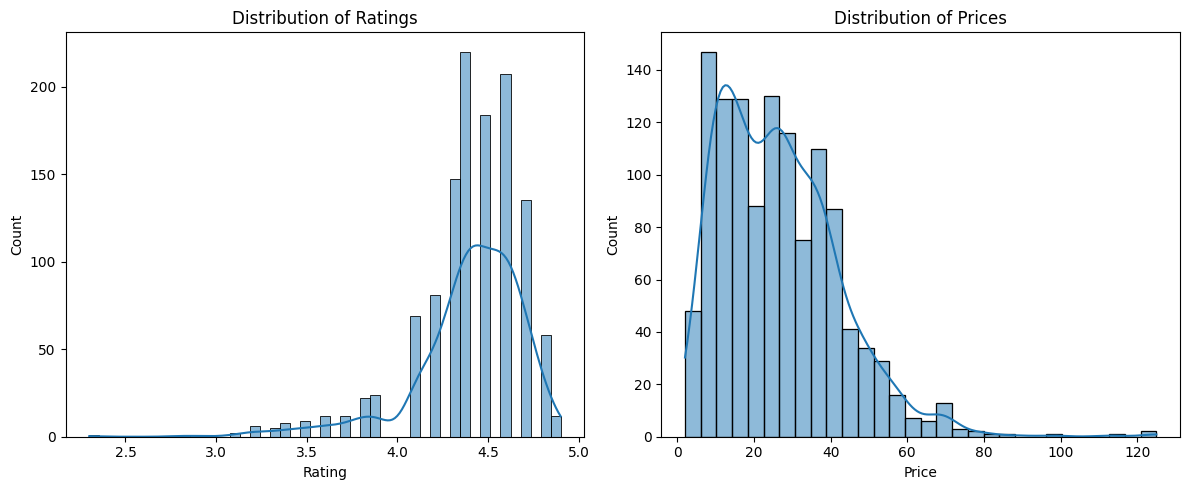

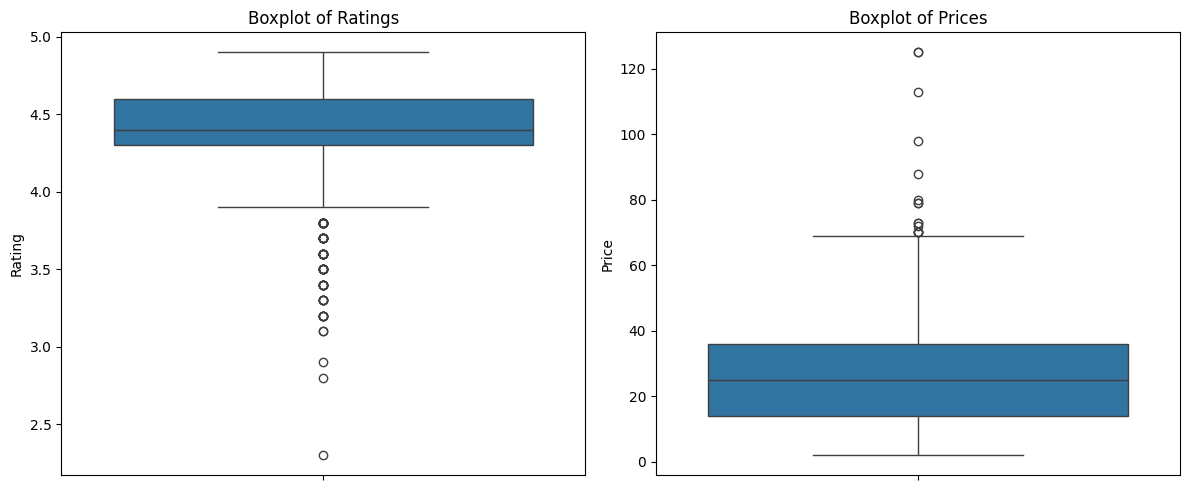

In [ ]:
# Visualizations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Rating'], kde=True)
plt.title('Distribution of Ratings')

plt.subplot(1, 2, 2)
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Prices')


plt.tight_layout()
plt.show()

# Boxplots to visualize central tendency and variability
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Rating'])
plt.title('Boxplot of Ratings')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price'])
plt.title('Boxplot of Prices')

plt.tight_layout()
plt.show()

<ipython-input-14-2eac78fb57b3>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Rating'], shade=True, color='darkgreen')
<ipython-input-14-2eac78fb57b3>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Price'], shade=True, color='purple')


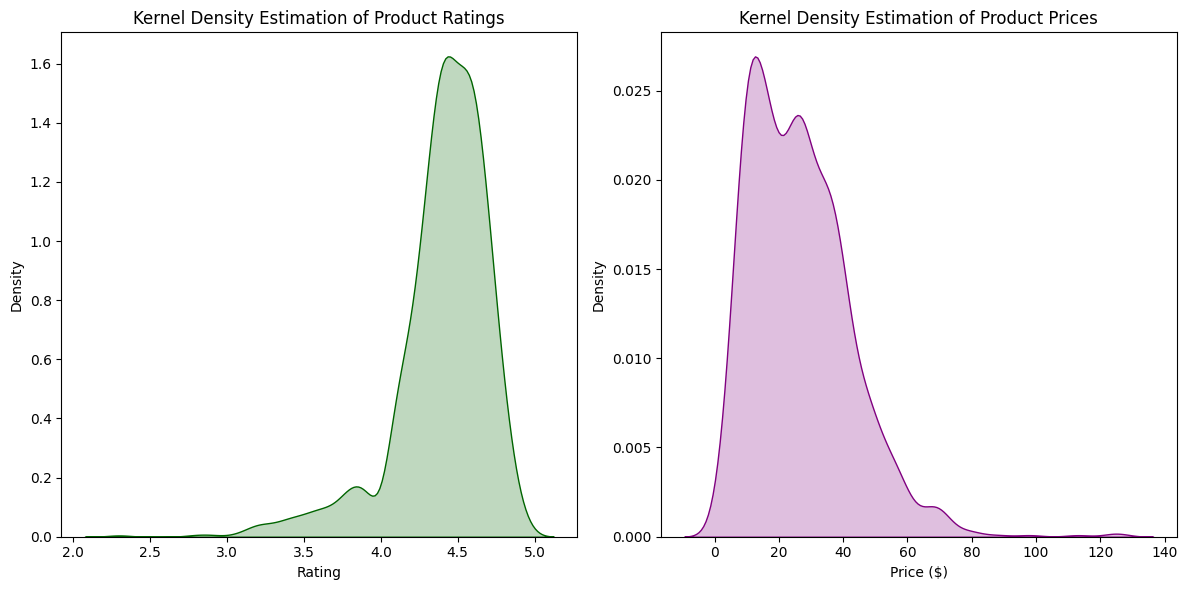

In [ ]:
# Kernel Density Estimate Plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(df['Rating'], shade=True, color='darkgreen')
plt.title('Kernel Density Estimation of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')


plt.subplot(1, 2, 2)
sns.kdeplot(df['Price'], shade=True, color='purple')
plt.title('Kernel Density Estimation of Product Prices')
plt.xlabel('Price ($)')
plt.ylabel('Density')


plt.tight_layout()
plt.show()


In [ ]:
# Calculate skewness and kurtosis
skewness_rating = skew(df['Rating'])
skewness_price = skew(df['Price'])
kurtosis_rating = kurtosis(df['Rating'])
kurtosis_price = kurtosis(df['Price'])

print(f"Skewness of Ratings: {skewness_rating}")
print(f"Skewness of Prices: {skewness_price}")
print(f"Kurtosis of Ratings: {kurtosis_rating}")
print(f"Kurtosis of Prices: {kurtosis_price}")

Skewness of Ratings: -1.7438562828686257
Skewness of Prices: 1.2113215802860486
Kurtosis of Ratings: 4.8855978417711645
Kurtosis of Prices: 3.2536722645937344


#4.Data Visualization


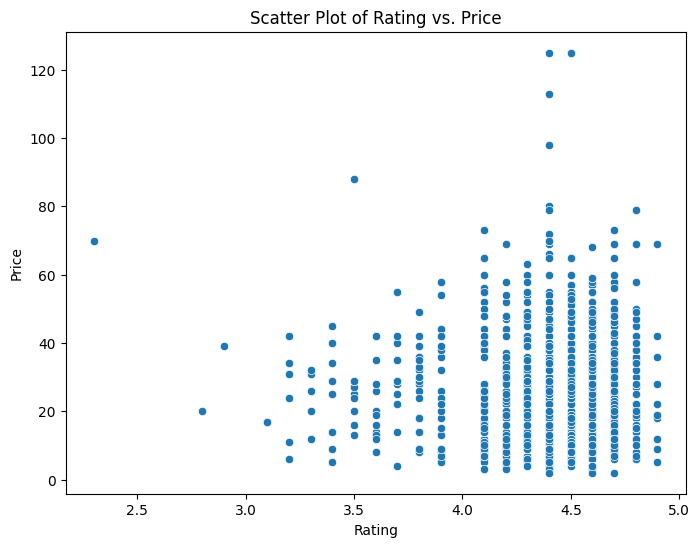

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Rating', y='Price', data=df)
plt.title('Scatter Plot of Rating vs. Price')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.show()

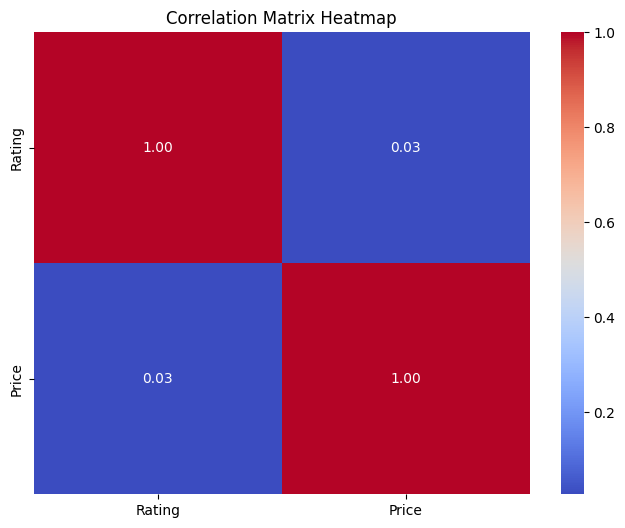

In [ ]:
correlation_matrix = df[['Rating', 'Price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

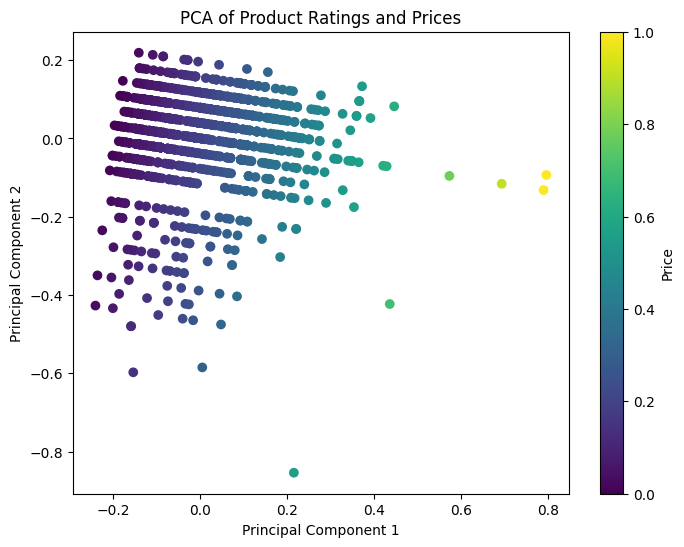

In [ ]:
scaler = MinMaxScaler()
df[['Rating', 'Price']] = scaler.fit_transform(df[['Rating', 'Price']])


pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[['Rating', 'Price']])


df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.title('PCA of Product Ratings and Prices')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

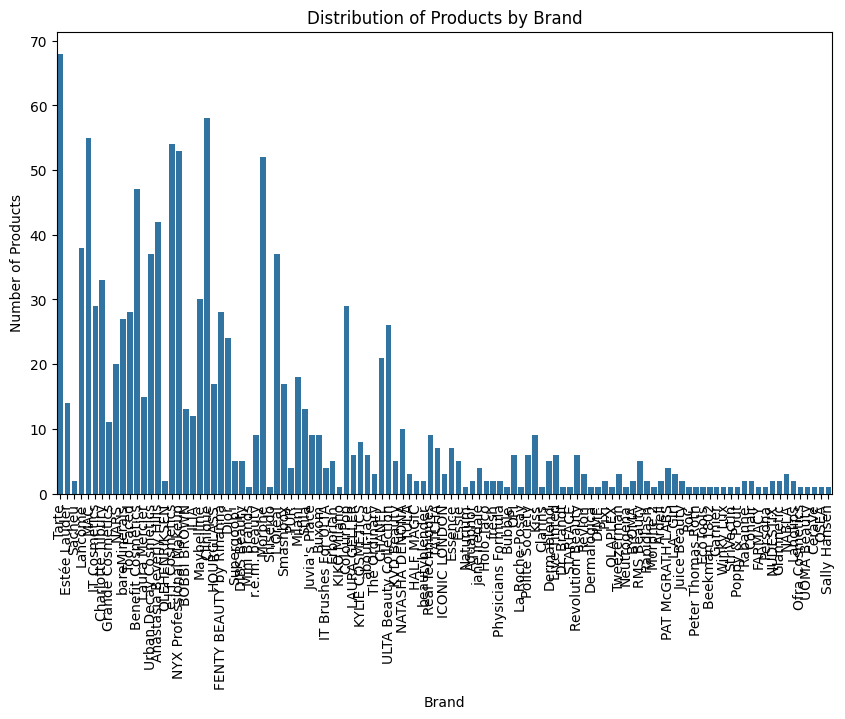

In [ ]:
plt.figure(figsize=(18, 8))  
sns.countplot(x='Brand', data=df)
plt.xticks(rotation=90, ha='right', fontsize=8) 
plt.title('Distribution of Products by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.tight_layout()  
plt.show()